# 3. Test model

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from wordcloud import WordCloud

In [2]:
from gensim.models import Word2Vec
import gensim.downloader as gensim_downloader
from api import GenderBiasScorer, EnsembleGenderBiasScorer, percentage_bias, biased_words

## 3.1 Test different vocab models on lexicons and tune thresholds
The evaluations employed are as follows:
1. Number of words from a given lexicon missing from the vocabulary. This shows whether dataset text has good coverage of the topic.
2. Performance on human-evaluated word pairing scores dataset from [gensim](https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html#evaluating). We see how well our word pair scores (e.g. `computer`+`laptop` should have high score, `computer`+`grass` should have low score) correlate to the human-labelled dataset. Disclaimer from [here](https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html#evaluating): "`Word2Vec` training is an unsupervised task, there’s no good way to objectively evaluate the result. Evaluation depends on your end application. Good performance on Google’s or WS-353 test set doesn’t mean word2vec will work well in your application, or vice versa. It’s always best to evaluate directly on your intended task." Hence the following...
3. Accuracy score on scoring labelled lexicons. As explained in [01_eda.ipynb](01_eda.ipynb), `test` lexicon is a "reality-check" to see if definitely gendered words, such as gender pronouns, are correctly scored, and `bias` lexicon sees if gender biases from the training (pseudo-scientifically) reflect pre-conceived psychological and sociological biases from the literature (more for interest: the results don't really reflect how good the model is).

First load models: models trained on 5 datasets, and one pretrained from Google (see [here](https://github.com/RaRe-Technologies/gensim-data))

In [3]:
model_names = ["wikibios_merged", "bug", "bug_stereotype", "doughman", "doughman_stereotype"]
scorers = [GenderBiasScorer(Word2Vec.load(f"models/dataset_{i}.pt").wv) for i in tqdm(model_names)]

100%|███████████████████████████████████████████████| 5/5 [00:01<00:00,  3.39it/s]


In [4]:
wv_pretrained = gensim_downloader.load('word2vec-google-news-300')
#wv_pretrained = gensim_downloader.load('glove-wiki-gigaword-100')

In [5]:
model_names.append("word2vec-google-news-300")
scorers.append(GenderBiasScorer(wv_pretrained))

Evaluate the models using methods above. Use the `test` lexicon to tune the scoring threshold. 

In [6]:
threshs = np.arange(0, 0.5, 0.02)

In [7]:
def tune_and_evaluate_models(scorers, model_names, threshs=threshs):
    # Tune scoring thresholds for models and return evaluation metrics
    threshs_optimal = np.zeros(len(scorers))
    test_accuracies = np.zeros(len(scorers))
    bias_accuracies = np.zeros(len(scorers))
    n_absent_words  = np.zeros(len(scorers))
    human_correlations = np.zeros(len(scorers))
    for i,scorer in enumerate(scorers):
        
        accuracies = np.zeros(len(threshs))
        for j,thresh in enumerate(threshs):
            accuracies[j] = scorer.lexicon_accuracy("test", thresh=thresh)

        threshs_optimal[i] = threshs[accuracies.argmax()]
        test_accuracies[i] = accuracies[accuracies.argmax()]
        bias_accuracies[i] = scorer.lexicon_accuracy("bias", thresh=threshs_optimal[i])
        human_correlations[i] = scorer.eval_gensim_human_dataset()
        n_absent_words[i] = scorer.lexicon_n_absent_words("bias")

    results = pd.DataFrame({"model_names": model_names, "n_absent_words": n_absent_words, 
                            "threshs_optimal": threshs_optimal, "test_accuracies": test_accuracies, 
                            "bias_accuracies": bias_accuracies, "human_correlations": human_correlations})
    return results

In [8]:
results = tune_and_evaluate_models(scorers, model_names, threshs)

<AxesSubplot:xlabel='model_names', ylabel='bias_accuracies'>

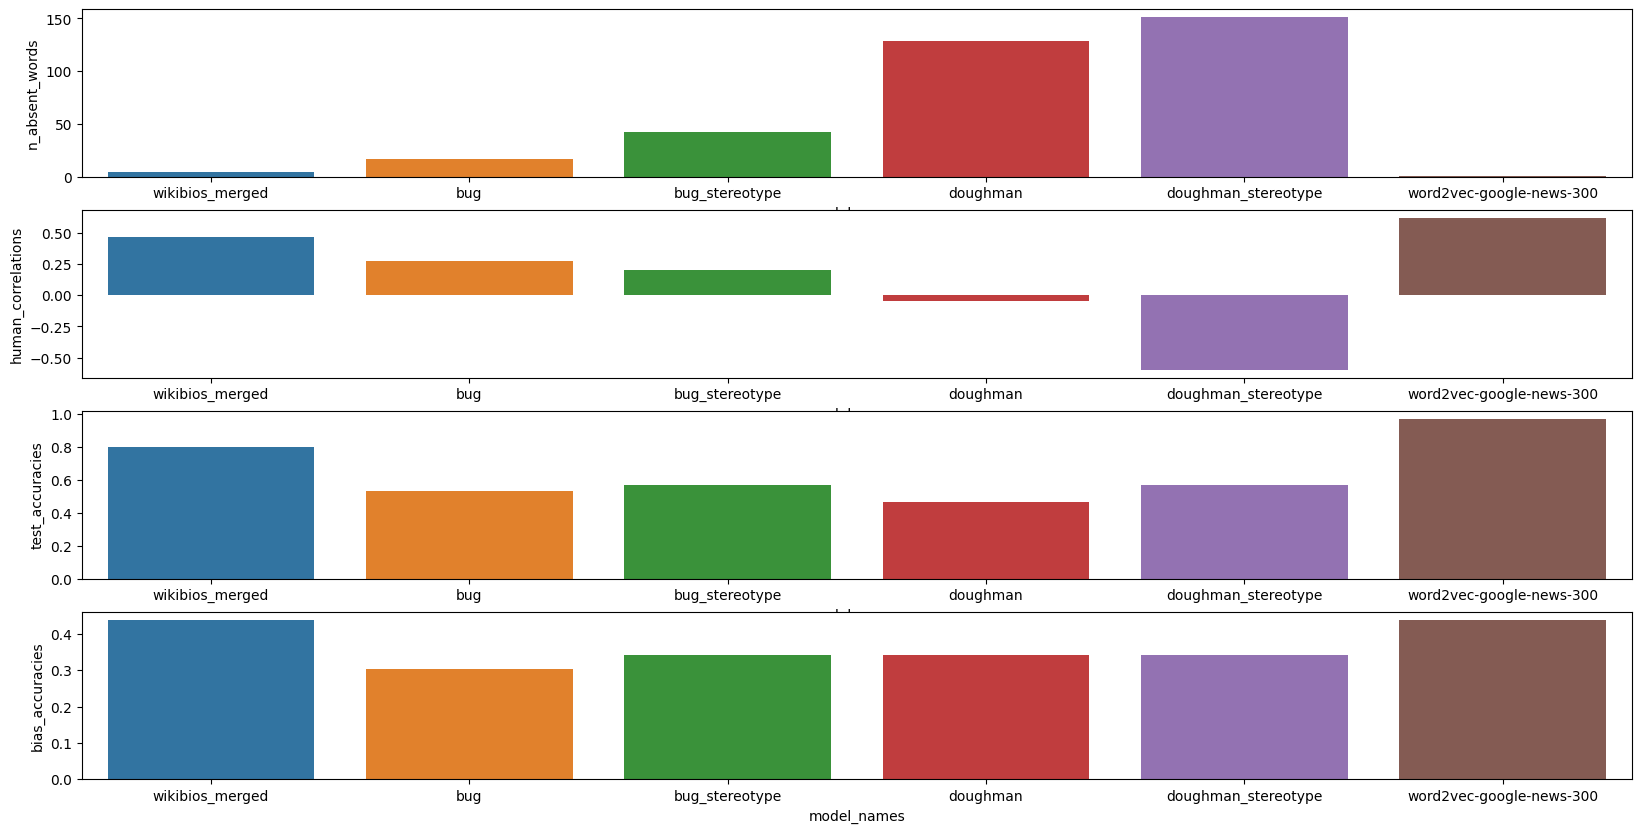

In [9]:
plt.figure(figsize=(20, 10))
plt.subplot(4,1,1)
sns.barplot(results, x="model_names", y="n_absent_words")
plt.subplot(4,1,2)
sns.barplot(results, x="model_names", y="human_correlations")
plt.subplot(4,1,3)
sns.barplot(results, x="model_names", y="test_accuracies")
plt.subplot(4,1,4)
sns.barplot(results, x="model_names", y="bias_accuracies")

## 3.2 Create ensemble model out of best `model.wv`s 

We see above that bug_stereotype, doughman and dougman_stereotype datasets are too small and their vocabs have too many missing words from the bias lexicon. They also have poor correlation on the word-pairs testing dataset. We choose models `wikibios_merged`, `bug`, and `word2vec-google-news-300` for creating an ensemble model, as they have good `test` lexicon accuracy. Each scorer in the ensemble model will have its own threshold. The ensemble model's gender bias scoring will take a majority-voting approach. Having more models in an ensemble method is expected to be more robust than a single model.

In [10]:
ensemble_scorer = EnsembleGenderBiasScorer(wvs=[Word2Vec.load(f"models/dataset_{i}.pt").wv for i in ["wikibios_merged", "bug"]] + [wv_pretrained],
                                       threshs=results[results["model_names"].isin(("wikibios_merged", "bug", "word2vec-google-news-300"))]["threshs_optimal"].to_numpy())

Compare original models with ensemble model

In [11]:
model_names = ["wikibios_merged", "bug", "word2vec-google-news-300", "ensemble"]
wvs = [Word2Vec.load(f"models/dataset_{i}.pt").wv for i in ["wikibios_merged", "bug"]] + [wv_pretrained]
scorers = [GenderBiasScorer(wv) for wv in wvs] + [ensemble_scorer]

results = tune_and_evaluate_models(scorers, model_names, threshs)

100%|███████████████████████████████████████████████| 3/3 [00:00<00:00,  9.83it/s]


<AxesSubplot:xlabel='model_names', ylabel='human_correlations'>

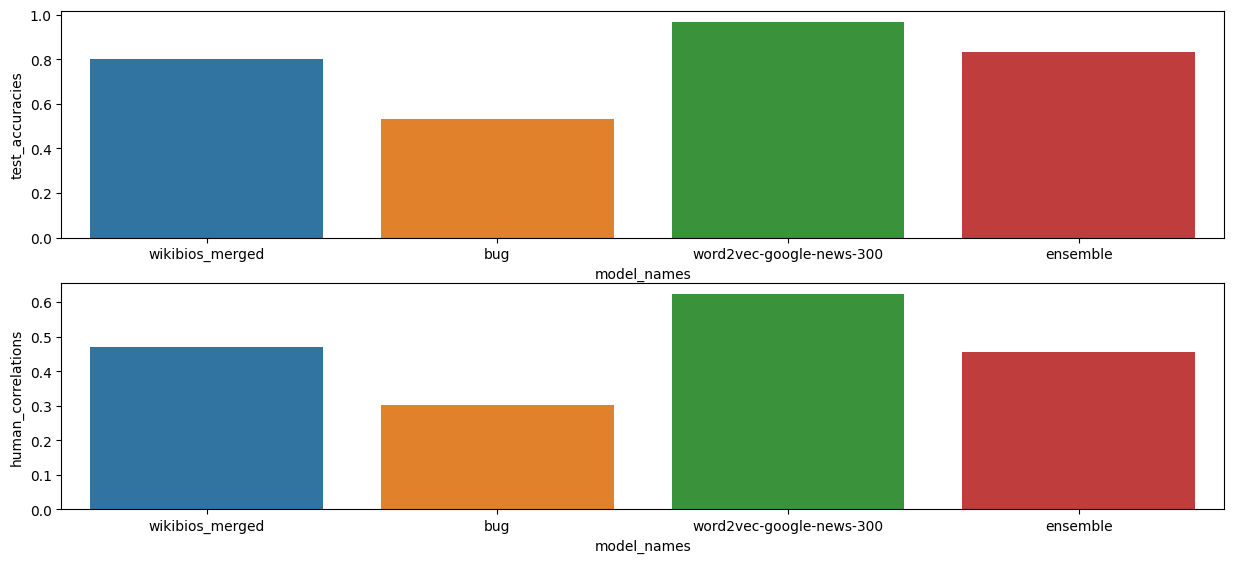

In [12]:
plt.figure(figsize=(15, 10))
plt.subplot(3,1,1)
sns.barplot(results, x="model_names", y="test_accuracies")
plt.subplot(3,1,2)
sns.barplot(results, x="model_names", y="bias_accuracies")
plt.subplot(3,1,2)
sns.barplot(results, x="model_names", y="human_correlations")

We see that the ensemble results are an average of the accuracies, so it's worse than the best. However, this means that, during scoring, any biased words must be voted in, making the model more robust.

## 3.3 Visualisations of final model on corpora
Firstly let's look at bias score and biased words in the doughman corpus, and visualise those words.

After some testing, the model as is gives lots of words, some of which aren't very realistically biased. After some playing around, we raise the thresholds manually to this to give more strongly biased words.

In [13]:
ensemble_scorer.threshs

array([0.26, 0.16, 0.08])

In [14]:
ensemble_scorer.threshs = [0.4, 0.8, 0.13]

In [15]:
with open("data/corpus/dataset_doughman.txt", "r") as f:
    document = " ".join(f.read().splitlines())

In [16]:
scorer = ensemble_scorer
tokens, scores = scorer.score_document(document)
words = biased_words(tokens, scores)
print(percentage_bias(document, scores))
print("m", set(words["biased_m"]))
print("f", set(words["biased_f"]))

1.0056640850768697
m {'game', 'heckle', 'captain', 'team', 'dude', 'club', 'man', 'guy', 'men', 'ball', 'himself'}
f {'nutritionist', 'caregiver', 'lisa', 'cardi', 'female', 'hygienist', 'psychotherapist', 'teresa', 'niece', 'woman', 'national', 'wendy', 'she', 'sophie', 'paralegal', 'homemaker', 'sylvia', 'boyfriend', 'kaur', 'sister'}


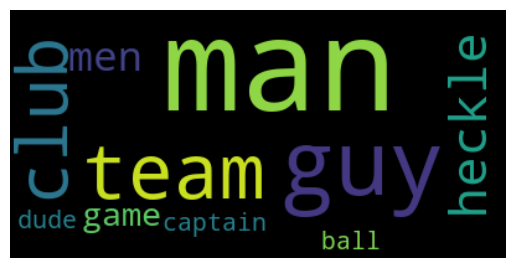

In [17]:
plt.imshow(WordCloud().generate(" ".join(words["biased_m"])), interpolation='bilinear')
plt.axis("off")
plt.show()

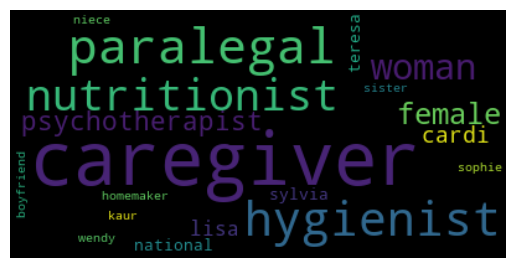

In [18]:
plt.imshow(WordCloud().generate(" ".join(words["biased_f"])), interpolation='bilinear')
plt.axis("off")
plt.show()

We see that the words systematically associated with male/female gender from the training data "from the wild" show up as gender biased, which have been recovered by this unsupervised method, e.g. "team" is biased because there might be a lot of unstructured text in the training data associating "team" with male gender words.

Similarly let's look at wikibios dataset...

In [24]:
with open("data/corpus/dataset_wikibios_merged.txt", "r") as f:
    documents = f.read().splitlines()

In [29]:
document = " ".join(documents[:2000])

In [30]:
scorer = ensemble_scorer
tokens, scores = scorer.score_document(document, progress=True)
words = biased_words(tokens, scores)
print(percentage_bias(document, scores))
print("m", set(words["biased_m"]))
print("f", set(words["biased_f"]))

100%|█████████████████████████████████████| 93779/93779 [00:14<00:00, 6512.98it/s]


2.188055153404098
m {'league', 'team', 'player', 'club', 'knock', 'teammate', 'captain', 'godfather', 'man', 'helmet', 'guy', 'crew', 'ball', 'game', 'duel', 'alias', 'ripper', 'squad', 'himself', 'tackling', 'maroon', 'jam', 'gunfighter', 'men', 'starter'}
f {'contralto', 'ayo', 'manish', 'herself', 'denise', 'female', 'classmates', 'businesswoman', 'sadhna', 'hostess', 'nana', 'spousal', 'susan', 'volleyball', 'christine', 'netball', 'transsexual', 'michelle', 'swimming', 'cynthia', 'fatale', 'angela', 'lisa', 'olivia', 'katie', 'nobile', 'national', 'fatima', 'goan', 'jessica', 'donna', 'heptathlete', 'beautician', 'eva', 'danielle', 'sophie', 'anna', 'lesbian', 'muse', 'rita', 'sati', 'sweetheart', 'laura', 'peggy', 'samantha', 'leah', 'sister', 'gender', 'latina', 'softball', 'baking', 'meena', 'chairperson', 'sandra', 'choti', 'liz', 'teresa', 'niece', 'natalie', 'nicole', 'social', 'heptathlon', 'christina', 'ipecac', 'wendy', 'suffrage', 'socialite', 'feminist', 'she', 'cheryl'

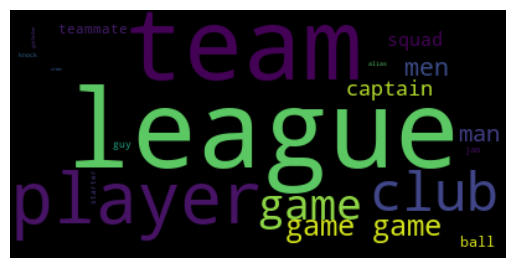

In [31]:
plt.imshow(WordCloud().generate(" ".join(words["biased_m"])), interpolation='bilinear')
plt.axis("off")
plt.show()

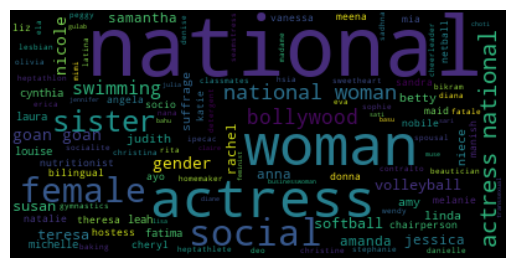

In [32]:
plt.imshow(WordCloud().generate(" ".join(words["biased_f"])), interpolation='bilinear')
plt.axis("off")
plt.show()

Now let's look at biased words from a bunch of kainos job descriptions (Data and AI roles).

In [33]:
with open("data/eval/kainosspecs.txt", "r") as f:
    document = " ".join(f.read().splitlines())

In [34]:
scorer = ensemble_scorer
tokens, scores = scorer.score_document(document)
words = biased_words(tokens, scores)
print(percentage_bias(document, scores))
print("m", set(words["biased_m"]))
print("f", set(words["biased_f"]))

1.1769101438445733
m {'team'}
f set()


Not many biased words!